# Introduction to Data Science and AI, Sofia, 2023

# Assignment 3: Clustering

*Submission by Dragomir Proychev*

***

*__1. Show the distribution of phi and psi combinations using:__*

- *__A scatter plot__*
- *__A 2D histogram__*

*__Make sure the plots are nice and clean. Can you modify them for better visualisation?__*

***

Let's start off by importing the data for the assignment.

In [1]:
import pandas as pd

df_proteins = pd.read_csv('data/data_assignment3.csv')

print(df_proteins)

      residue name  position chain         phi         psi
0              LYS        10     A -149.312855  142.657714
1              PRO        11     A  -44.283210  136.002076
2              LYS        12     A -119.972621 -168.705263
3              LEU        13     A -135.317212  137.143523
4              LEU        14     A -104.851467   95.928520
...            ...       ...   ...         ...         ...
29364          GLY       374     B -147.749557  155.223562
29365          GLN       375     B -117.428541  133.019506
29366          ILE       376     B -113.586448  112.091970
29367          ASN       377     B -100.668779  -12.102821
29368          LYS       378     B -169.951240   94.233680

[29369 rows x 5 columns]


Before visualizing the data, let's check for any missing values.

In [2]:
df_proteins.isnull().any()

residue name    False
position        False
chain           False
phi             False
psi             False
dtype: bool

We can move on to the visualization of the data using a scatter plot.

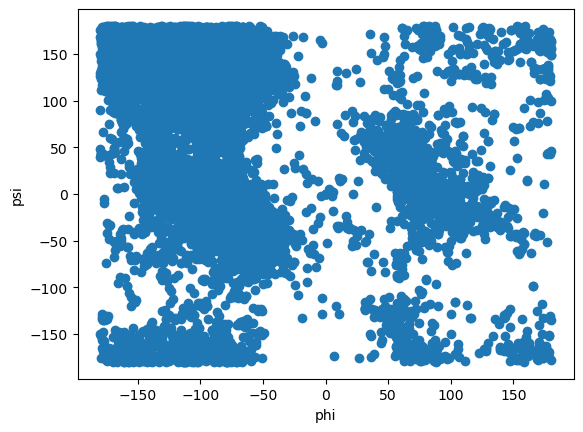

In [3]:
import matplotlib.pyplot as plt

plt.scatter(
    df_proteins['phi'],
    df_proteins['psi'],
)

plt.xlabel('phi')
plt.ylabel('psi')

plt.show()

Let's visualize the data using a 2d histogram as well.

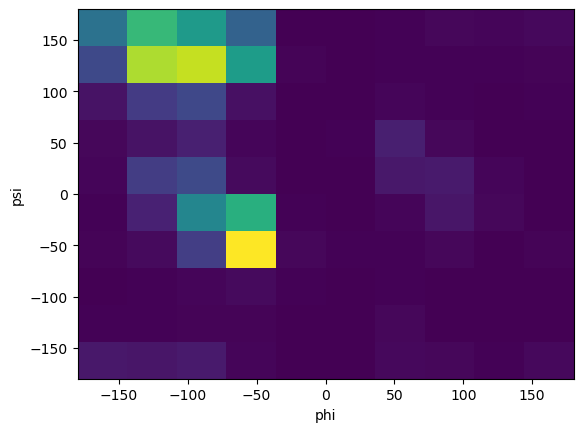

In [4]:
import matplotlib.pyplot as plt

plt.hist2d(
    df_proteins['phi'],
    df_proteins['psi']
)

plt.xlabel('phi')
plt.ylabel('psi')

plt.show()

***

*__Use the K-means clustering method to cluster the phi and psi angle combinations in
the data file.__*

*__a. Experiment with different values of K. Suggest an appropriate value of K for this
task and motivate this choice.__*

***

Let's experiment with values of K in the range between 1 and 10. We'll try to determine an appropriate value for K using the elbow method.

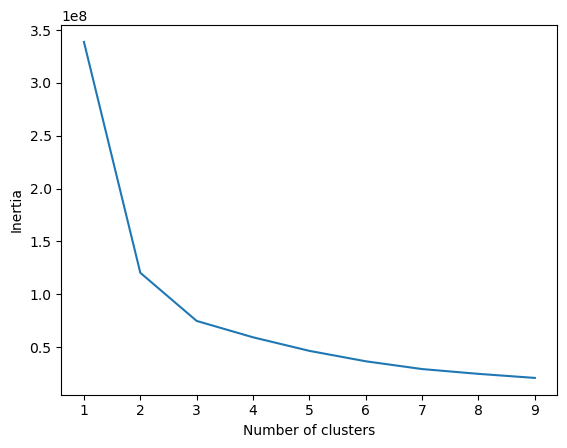

In [5]:
from sklearn.cluster import KMeans

df_angles = df_proteins[['phi', 'psi']]

inertia = {}

for k in range(1, 10):
    model = KMeans(n_clusters=k, n_init=10).fit(df_angles)
    inertia[k] = model.inertia_

plt.figure()

plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.show()

Based on our observations, the most appropriate value for K seems to be 3.

Let's visualize the clusters for K = 3 by using a scatter plot.

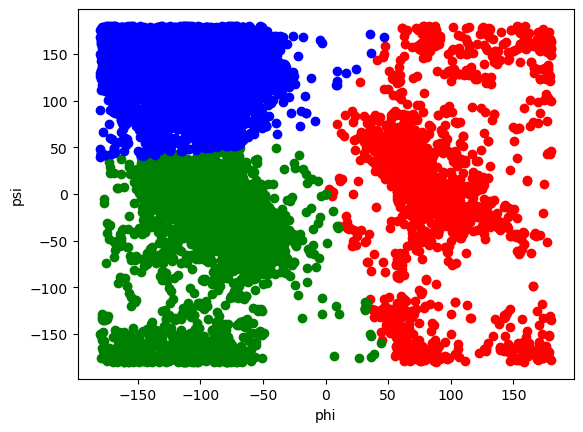

In [6]:
model = KMeans(n_clusters=3, n_init=10)

labels = model.fit_predict(df_angles)

cluster1 = df_angles[labels == 0]
cluster2 = df_angles[labels == 1]
cluster3 = df_angles[labels == 2]

plt.scatter(cluster1['phi'] , cluster1['psi'] , color = 'red')
plt.scatter(cluster2['phi'] , cluster2['psi'] , color = 'green')
plt.scatter(cluster3['phi'] , cluster3['psi'] , color = 'blue')

plt.xlabel('phi')
plt.ylabel('psi')

plt.show()

***

*__b. Do the clusters found in part (a) seem reasonable?__*

***

While the clusters found in part (a) seem acceptable at a first glance, they are definitely not optimal.

One of the reasons is that the red and the green clusters could actually be part of the same cluster.

Another reason is that the top edge of the Ramachandran plot wraps around to the bottom edge, which we have not taken into account when building our model.

***

*__3. Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.__*

*__a. Motivate the choice of:__*
- *__the minimum number of samples in the neighbourhood for a point to be considered as a core point__*
- *__the maximum distance between two samples belonging to the same neighbourhood (“eps” or “epsilon”)__*

*__Compare the clusters found by DBSCAN with those found using K-means.__*

*__b. Highlight the clusters found using DBSCAN and any outliers in a scatter plot.__*

***

Let's start of by determining the minimum number of samples and maximum distance between two samples for our model.

- We are working on a two dimensional dataset, so using the recommended formula of `MinPts = 2 * D` , we can deduce that a value of 4 would be appropriate for the minimum number of samples.
- To determine an appropriate value for the maximum distance between two samples, we can plot the sorted values of a k-distance graph where `k = MinPts` and identify the elbow of the plot.

For our next steps we'll define reusable functions which we will be able to use in task 4. as well.

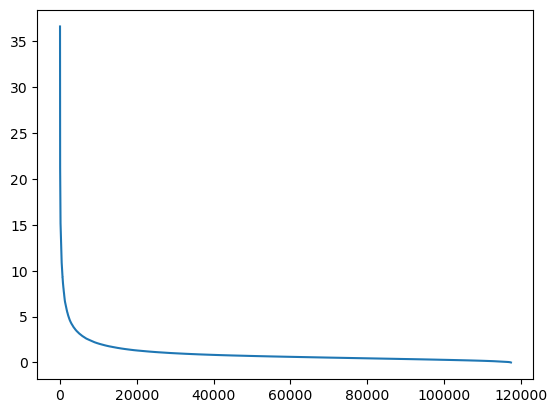

In [7]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import kneighbors_graph

def plot_neighbors_distances(df):
    distances = kneighbors_graph(df, 4, mode='distance').data
    distances = np.sort(distances)[::-1]
    plt.plot(distances)

    plt.show()

plot_neighbors_distances(df_angles)

Based on our observations, we can use a value of 5 for the maximum distance between two samples.

Let's run a DBSCAN model and plot out the clusters.

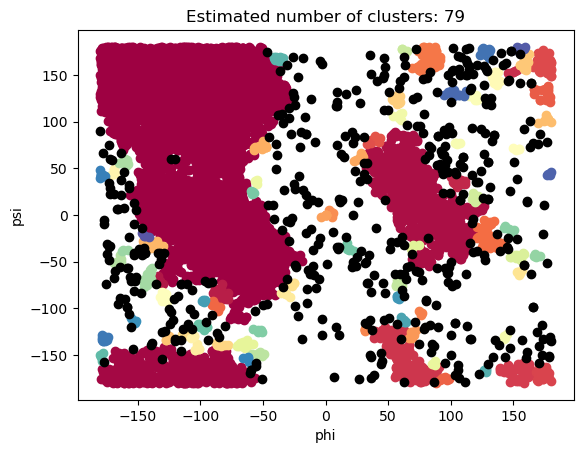

In [8]:
from sklearn.cluster import DBSCAN

def run_db_scan(df, eps):
    model = DBSCAN(eps=eps, min_samples=4).fit(df)
    labels = model.labels_
    
    return labels

def plot_db_scan(df, labels):
    unique_labels = set(labels)

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    black_color = [0, 0, 0, 1]

    for k, color in zip(unique_labels, colors):
        if k == -1:
            color = black_color

        plt.scatter(
            df[labels == k]['phi'],
            df[labels == k]['psi'],
            color=tuple(color),
        )

    plt.xlabel('phi')
    plt.ylabel('psi')
    
    num_clusters = labels.max() + 1
    
    plt.title(f'Estimated number of clusters: {num_clusters}')

    plt.show()
    
labels = run_db_scan(df_angles, 5)
plot_db_scan(df_angles, labels)

The results seem acceptable at a first glance, however a bit noisy. There are a lot of small clusters which could be part of larger clusters.

We can try remedying this by increasing the value for the maximum distance. Let's try out using a value of 10 instead.

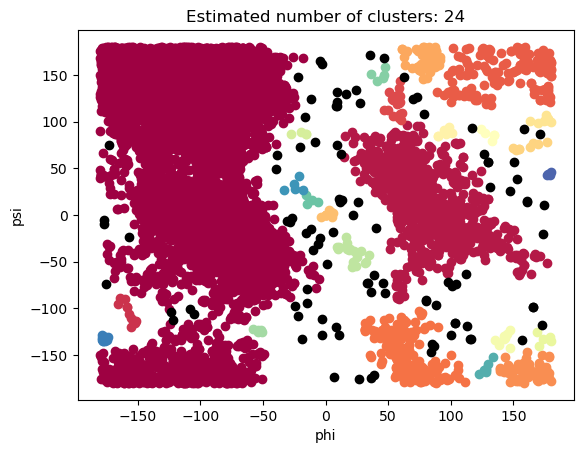

In [9]:
labels = run_db_scan(df_angles, 10)
plot_db_scan(df_angles, labels)

These results look a lot better. There are still a significant amount of smaller clusters, however they are better defined and self contained.

When comparing the results to the K means model, we can observe that the larger clusters seem better defined.

***

*__c.How many outliers are found? Plot a bar chart to show how often each of the
amino acid residue types are outliers.__*

***

In [10]:
labels = run_db_scan(df_angles, 10)

outliers_count = labels[labels == -1].size
clustered_count = labels[labels != -1].size

print(f'Outliers count: {outliers_count}')
print(f'Clustered count: {clustered_count}')

Outliers count: 102
Clustered count: 29267


Let's plot a bar chart. It might be a good idea to use a logarithmic scale, because of the huge difference between the two metrics.

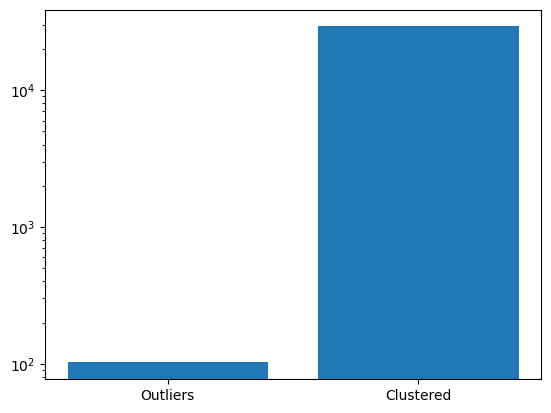

In [11]:
plt.bar(('Outliers', 'Clustered'), (outliers_count, clustered_count), log=True)

plt.show()

***

*__4. The data file can be stratified by amino acid residue type. Use DBSCAN to cluster the
data that have residue type PRO. Investigate how the clusters found for amino acid
residues of type PRO differ from the general clusters (i.e., the clusters that you get
from DBSCAN with mixed residue types in question 3).__*

*__Note: the parameters might have to be adjusted from those used in question 3.__*

***

Let's start by filtering the data.

In [12]:
df_angles = df_angles.loc[df_proteins['residue name'] == 'PRO']

print(df_angles)

             phi         psi
1     -44.283210  136.002076
17    -49.944645  -25.888991
68    -76.452014   97.745207
110   -53.054020  -27.254912
123   -66.751364   94.099782
...          ...         ...
29284 -54.565923  -42.141418
29339 -66.803083  136.260650
29340 -59.612140  160.048387
29347 -48.679835  135.208297
29356 -61.621274  -41.694960

[1596 rows x 2 columns]


We can use the same value for the minimum number of samples in a cluster.

Let's try do determine the optimal value for the maximum distance between two samples, using the elbow method.

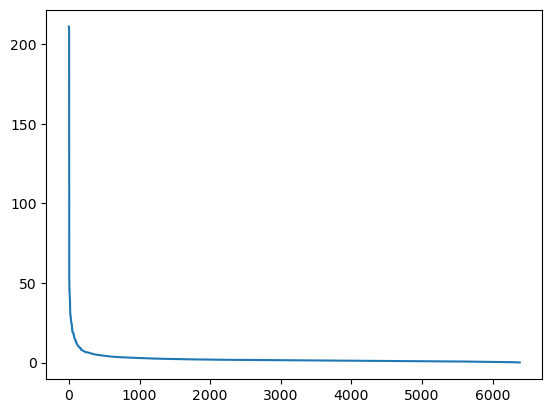

In [13]:
plot_neighbors_distances(df_angles)

Based on our observations, we can use a value of 10 for the maximum distance between two samples.

Let's run a DBSCAN model and plot out the clusters.

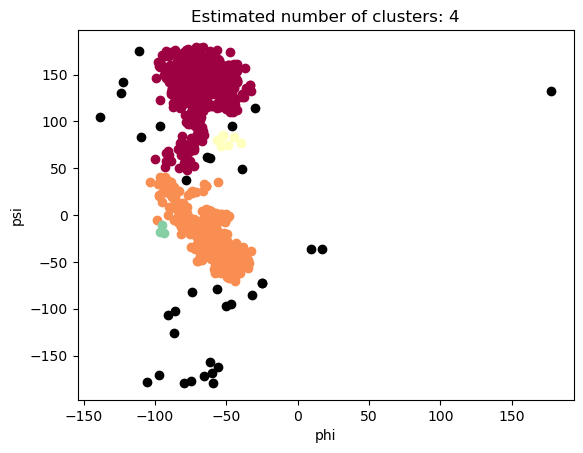

In [14]:
labels = run_db_scan(df_angles, 10)
plot_db_scan(df_angles, labels)

There are significantly less clusters for the residues of type PRO in comparison to the clusters in task 3. They are more concentrated and better defined.